### Experimental Parameters

In [1]:
import numpy as np

proposal_rates = np.linspace(0.01, 0.5, 3)
n_trials = 2

### Setup JSON File

In [2]:
import json

# Create experimental parameters and write to JSON file

params = {'Block proposal rate parameter': 0,
 'Block size (txs)': 50,
 'Duration (sec)': 2400,
 'Fork choice rule': 'longest-chain',
 'Network model': 'Decker-Wattenhorf',
 'Number of adversaries': 1,
 'Number of nodes': 100,
 'Probability of error in transaction confirmation': 0.1,
 'Transaction dataset': 'poisson'}
d = {}
for i in range(0, len(proposal_rates)):
    params['Block proposal rate parameter'] = proposal_rates[i]
    d[f'longest-chain-{i}'] = params


### Run experiments

In [3]:
import os, shutil
from IPython.core.display import Image 

os.chdir('..')

import metrics

throughputs = {}
main_chain_arrival_latencies = {}
finalization_latencies = {}

for i in range(0, len(proposal_rates)):
    rate = proposal_rates[i]
    d['setting-name'] = f'longest-chain-{i}'
    with open('results/longest_chain.json', 'w+') as outfile:
        json.dump(d, outfile)
    throughputs[rate] = []
    main_chain_arrival_latencies[rate] = []
    finalization_latencies[rate] = []
    global_blocktrees[rate] = []
    for trial in range(0, n_trials):
        os.system('python3 main.py -f results/longest_chain.json')
        throughput = metrics.compute_throughput()
        avg_main_chain_arrival_latency, avg_finalization_latency = metrics.compute_latency()
        throughputs[rate].append(throughput)
        main_chain_arrival_latencies[rate].append(avg_main_chain_arrival_latency)
        finalization_latencies[rate].append(avg_finalization_latency)
        Image('stats/global-blocktree.png')

os.chdir('results/')
os.remove('longest_chain.json')

print('Throughputs:\n', throughputs)
print('Main Chain Arrival Latencies:\n', main_chain_arrival_latencies)
print('Finalization Latencies:\n', finalization_latencies)

Throughputs:
 {0.01: [1, 1], 0.255: [1, 1], 0.5: [1, 1]}
Main Chain Arrival Latencies:
 {0.01: [4.429647310989255, 3.9961114318409785], 0.255: [4.15071526805891, 4.725149018788652], 0.5: [4.261433582325468, 4.475766802867039]}
Finalization Latencies:
 {0.01: [29.475932455438844, 27.440548613068394], 0.255: [28.40468859578965, 29.904986058990367], 0.5: [28.921424292275972, 30.259287831635273]}


### Compute Averages

Average main chain latency is the time for a transaction to be added to the global blocktree - the timestamp the transaction was created.

Average finalization latency is the time for a transaction to be k blocks deep - to be added to the global blocktree.

In [4]:
avg_main_chain_latencies = {}
for rate in main_chain_arrival_latencies:
    avg_main_chain_latencies[rate] = sum(main_chain_arrival_latencies[rate])/len(main_chain_arrival_latencies[rate])

print("Average Main Chain Arrival Latency:", avg_main_chain_latencies)
avg_finalization_latencies = {}
for rate in finalization_latencies:
    avg_finalization_latencies[rate] = sum(finalization_latencies[rate])/len(finalization_latencies[rate])
    
print("Average Finalization Latency:", avg_finalization_latencies)


Average Main Chain Arrival Latency: {0.01: 4.2128793714151165, 0.255: 4.437932143423781, 0.5: 4.368600192596253}
Average Finalization Latency: {0.01: 28.45824053425362, 0.255: 29.15483732739001, 0.5: 29.590356061955625}


### Extract Finalization Depth and Delta for Blocks

In [5]:
import csv
with open('../logs/stats.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[0]=='Finalization depth':
            k = int(row[1])
        elif row[0]=='Average network latency for blocks (sec)':
            delta = float(row[1])

### Plotting the results

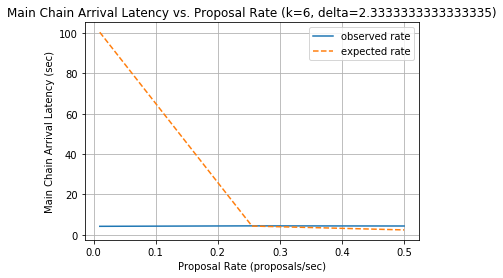

In [7]:
import matplotlib.pylab as plt
x = avg_main_chain_latencies.keys()
y1 = avg_main_chain_latencies.values()
expected_y1 = (1.0/delta+1.0/proposal_rates)
y2 = avg_finalization_latencies.values()
expected_y2 = k*(1.0/delta+1.0/proposal_rates)

plt.xlabel('Proposal Rate (proposals/sec)')
plt.ylabel('Main Chain Arrival Latency (sec)')
plt.title(f'Main Chain Arrival Latency vs. Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y1, label='observed rate')
plt.plot(x, expected_y1, '--', label='expected rate')
plt.legend()
plt.show()

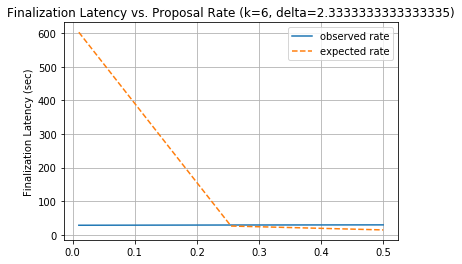

In [8]:
plt.ylabel('Finalization Latency (sec)')
plt.title(f'Finalization Latency vs. Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y2, label='observed rate')
plt.plot(x, expected_y2, '--', label='expected rate')
plt.legend()
plt.show()